Device: cpu
Starting Corrected Delta Analysis for AAPL
Generating options data for AAPL at $150.00
Preparing training data with 50 calls and 50 puts...
Selected 50 calls and 50 puts
Training corrected CNN model...
Epoch 0/100 - Train Loss: 0.068370, Val Loss: 0.058084
Epoch 20/100 - Train Loss: 0.012361, Val Loss: 0.014756
Epoch 40/100 - Train Loss: 0.008805, Val Loss: 0.014864
Epoch 60/100 - Train Loss: 0.004637, Val Loss: 0.013353
Epoch 80/100 - Train Loss: 0.006524, Val Loss: 0.013854
Training completed. Best validation loss: 0.011336

Model Performance:
MSE: 0.003648
MAE: 0.045027

DELTA ANALYSIS FOR AAPL (Stock Price: $150.00)

🔵 CALL OPTIONS (50 selected):
  Strike  Moneyness    Delta     Status   Days
--------------------------------------------------
   120.0      0.800    0.787   Deep ITM      7
   120.0      0.800    0.783   Deep ITM     14
   120.0      0.800    0.801   Deep ITM     30
   120.0      0.800    0.811   Deep ITM     60
   125.0      0.833    0.787   Deep ITM    

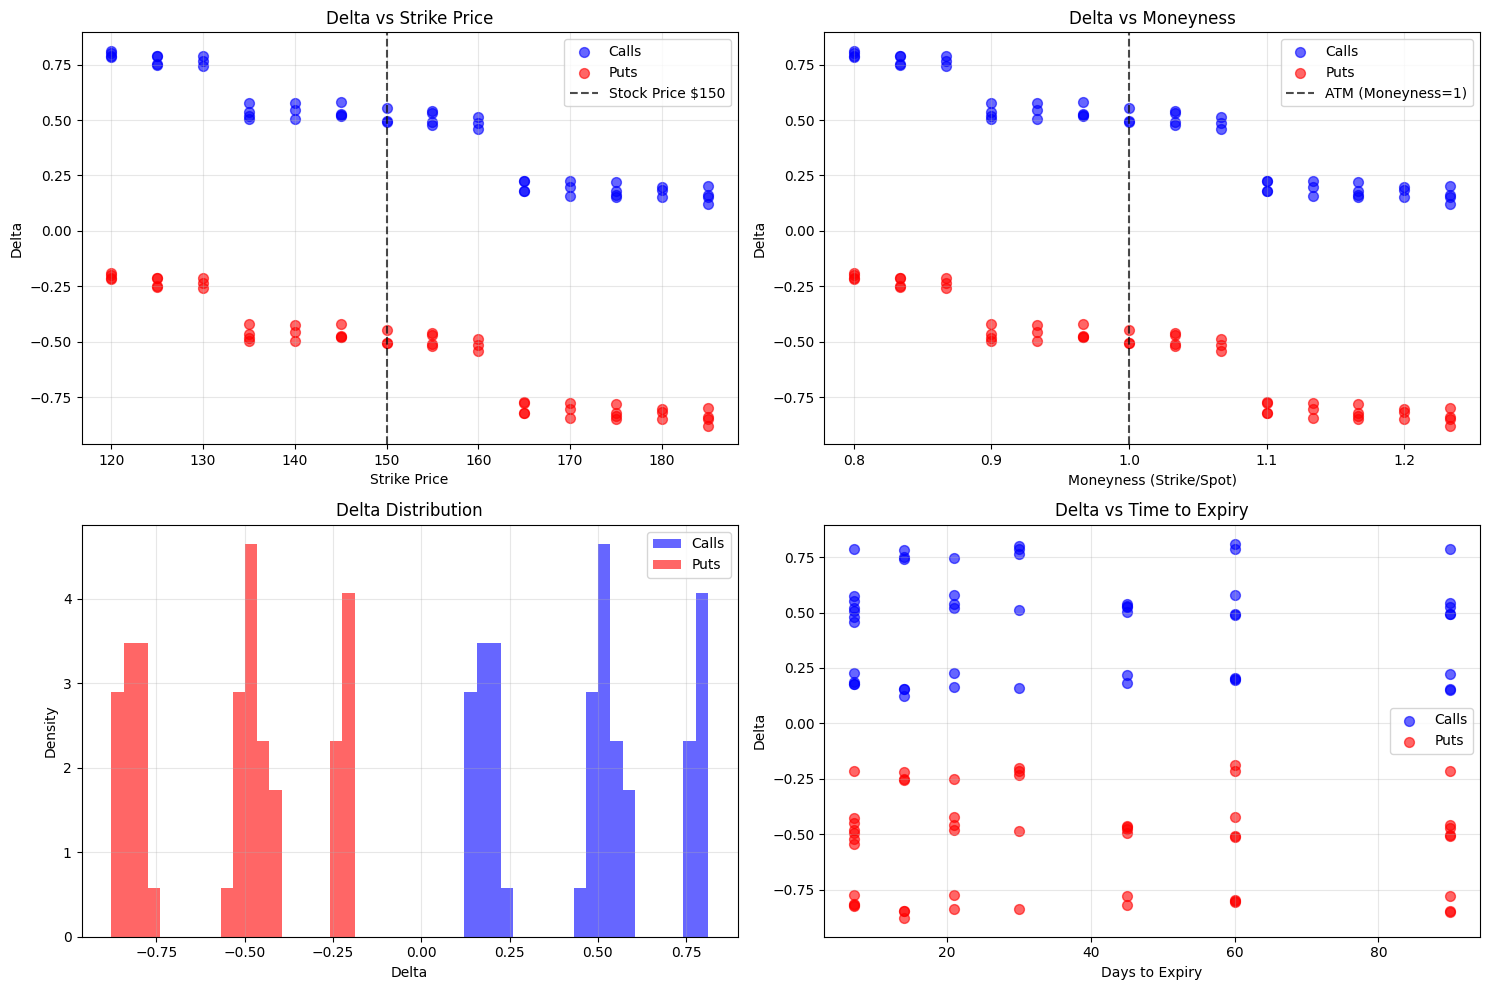

Delta analysis plots saved to 'corrected_delta_analysis.png'

Analysis complete! Check the detailed strike price and delta listings above.
Generated files:
- corrected_delta_analysis.png
- best_corrected_model.pth


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import requests
import os
from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')

# Load environment variables
load_dotenv()
ALPHA_VANTAGE_API_KEY = os.getenv('ALPHA_VANTAGE_API_KEY')

class OptionsDataset(Dataset):
    """Dataset for options with data augmentation"""
    def __init__(self, features, targets, option_types, augment=False):
        self.features = torch.from_numpy(features.astype(np.float32))
        self.targets = torch.from_numpy(targets.astype(np.float32))
        self.option_types = torch.from_numpy(option_types.astype(np.float32))
        self.augment = augment
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        features = self.features[idx]
        targets = self.targets[idx]
        option_type = self.option_types[idx]
        
        if self.augment and torch.rand(1) > 0.5:
            noise = torch.normal(0, 0.005, features.shape)
            features = features + noise
            
        return features, targets, option_type

class CorrectedCNNDeltaPredictor(nn.Module):
    """Corrected CNN delta predictor with proper put/call delta handling"""
    def __init__(self, input_features=8, hidden_channels=64):
        super(CorrectedCNNDeltaPredictor, self).__init__()
        
        self.input_features = input_features
        
        # Feature extraction layers
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_features, hidden_channels * 2),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.GELU(),
            nn.Dropout(0.2),
            
            nn.Linear(hidden_channels * 2, hidden_channels * 3),
            nn.BatchNorm1d(hidden_channels * 3),
            nn.GELU(),
            nn.Dropout(0.1),
            
            nn.Linear(hidden_channels * 3, hidden_channels * 2),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.GELU(),
        )
        
        # Option type embedding
        self.option_type_embedding = nn.Embedding(2, 32)
        
        # Combined feature size
        combined_size = hidden_channels * 2 + 32
        
        # Shared layers before branching
        self.shared_layers = nn.Sequential(
            nn.Linear(combined_size, hidden_channels),
            nn.GELU(),
            nn.Dropout(0.1),
        )
        
        # Final prediction layer - outputs absolute delta
        self.predictor = nn.Sequential(
            nn.Linear(hidden_channels, 32),
            nn.GELU(),
            nn.Linear(32, 1),
            nn.Sigmoid()  # Output 0 to 1
        )
        
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
    
    def forward(self, x, option_types):
        # Extract features
        features = self.feature_extractor(x)
        
        # Option type embedding
        type_emb = self.option_type_embedding(option_types.long())
        
        # Combine features
        combined = torch.cat([features, type_emb], dim=1)
        
        # Shared processing
        shared_out = self.shared_layers(combined)
        
        # Get absolute delta (0 to 1)
        abs_delta = self.predictor(shared_out)
        
        # Apply correct sign based on option type
        # Call options: delta stays positive (0 to 1)
        # Put options: delta becomes negative (0 to -1)
        call_mask = (option_types == 1).float().unsqueeze(1)
        put_mask = (option_types == 0).float().unsqueeze(1)
        
        # Calls: positive delta, Puts: negative delta
        delta = call_mask * abs_delta + put_mask * (-abs_delta)
        
        return delta

class CorrectedOptionsPredictor:
    def __init__(self, api_key=None):
        self.api_key = api_key
        self.base_url = "https://www.alphavantage.co/query"
        self.scaler = RobustScaler()
        self.model = None
        self.model_trained = False
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.current_stock_price = None
        self.training_history = {'loss': [], 'val_loss': []}
        
        print(f"Device: {self.device}")
    
    def generate_realistic_options_data(self, symbol='AAPL', stock_price=150.0):
        """Generate realistic options data with proper delta relationships"""
        print(f"Generating options data for {symbol} at ${stock_price:.2f}")
        
        self.current_stock_price = stock_price
        options_list = []
        
        # Create strike prices around current price
        strike_range = np.arange(stock_price * 0.8, stock_price * 1.25, 5.0)
        expiration_days = [7, 14, 21, 30, 45, 60, 90]
        
        for strike in strike_range:
            for days in expiration_days:
                moneyness = strike / stock_price
                time_to_expiry = days / 365.0
                
                # Standard Black-Scholes-like delta calculation
                # For calls: higher delta when ITM (strike < spot)
                # For puts: more negative delta when ITM (strike > spot)
                
                # Call delta calculation
                if moneyness < 0.9:  # Deep ITM calls
                    call_delta = 0.75 + 0.20 * (0.9 - moneyness) + 0.05 * np.sqrt(time_to_expiry)
                elif moneyness < 1.1:  # ATM calls
                    call_delta = 0.5 + 0.25 * (1 - moneyness) + 0.05 * np.sqrt(time_to_expiry)
                else:  # OTM calls
                    call_delta = 0.25 * np.exp(-(moneyness - 1) * 2) + 0.02 * np.sqrt(time_to_expiry)
                
                # Ensure call delta is in valid range
                call_delta = np.clip(call_delta + np.random.normal(0, 0.03), 0.01, 0.99)
                
                # Put delta: call_delta - 1 (put-call parity relationship)
                put_delta = call_delta - 1
                
                # Generate market data
                iv = np.random.uniform(0.15, 0.45)
                volume_call = np.random.randint(10, 1000)
                volume_put = np.random.randint(10, 1000)
                
                # Add call option
                intrinsic_call = max(0, stock_price - strike)
                time_value_call = iv * np.sqrt(time_to_expiry) * stock_price * 0.4
                theo_price_call = intrinsic_call + time_value_call
                
                options_list.append({
                    'symbol': symbol,
                    'type': 'call',
                    'strike': strike,
                    'expiration': (datetime.now() + timedelta(days=days)).strftime('%Y-%m-%d'),
                    'bid': max(0.01, theo_price_call - 0.10),
                    'ask': theo_price_call + 0.10,
                    'last': theo_price_call,
                    'volume': volume_call,
                    'open_interest': np.random.randint(50, 5000),
                    'implied_volatility': iv,
                    'delta': call_delta,
                    'days_to_expiry': days
                })
                
                # Add put option
                intrinsic_put = max(0, strike - stock_price)
                time_value_put = iv * np.sqrt(time_to_expiry) * stock_price * 0.4
                theo_price_put = intrinsic_put + time_value_put
                
                options_list.append({
                    'symbol': symbol,
                    'type': 'put',
                    'strike': strike,
                    'expiration': (datetime.now() + timedelta(days=days)).strftime('%Y-%m-%d'),
                    'bid': max(0.01, theo_price_put - 0.10),
                    'ask': theo_price_put + 0.10,
                    'last': theo_price_put,
                    'volume': volume_put,
                    'open_interest': np.random.randint(50, 5000),
                    'implied_volatility': iv,
                    'delta': put_delta,
                    'days_to_expiry': days
                })
        
        return pd.DataFrame(options_list)
    
    def select_50_options_by_type(self, df, option_type='call', target_count=50):
        """Select 50 options of specified type with good distribution"""
        type_df = df[df['type'] == option_type].copy()
        
        if len(type_df) <= target_count:
            return type_df
        
        # Sort by moneyness to get good distribution
        type_df['moneyness'] = type_df['strike'] / self.current_stock_price
        type_df = type_df.sort_values('moneyness')
        
        # Select evenly distributed options
        indices = np.linspace(0, len(type_df) - 1, target_count).astype(int)
        selected = type_df.iloc[indices].copy()
        
        return selected
    
    def prepare_training_data(self, options_df):
        """Prepare training data with exactly 50 calls and 50 puts"""
        print("Preparing training data with 50 calls and 50 puts...")
        
        # Select exactly 50 calls and 50 puts
        calls_df = self.select_50_options_by_type(options_df, 'call', 50)
        puts_df = self.select_50_options_by_type(options_df, 'put', 50)
        
        # Combine
        final_df = pd.concat([calls_df, puts_df], ignore_index=True)
        
        print(f"Selected {len(calls_df)} calls and {len(puts_df)} puts")
        
        # Feature engineering
        final_df['moneyness'] = final_df['strike'] / self.current_stock_price
        final_df['log_moneyness'] = np.log(final_df['moneyness'])
        final_df['sqrt_time'] = np.sqrt(final_df['days_to_expiry'] / 365)
        final_df['log_time'] = np.log(final_df['days_to_expiry'] / 365 + 1e-6)
        final_df['log_volume'] = np.log1p(final_df['volume'])
        final_df['log_open_interest'] = np.log1p(final_df['open_interest'])
        final_df['moneyness_time'] = final_df['moneyness'] * final_df['sqrt_time']
        final_df['iv_time'] = final_df['implied_volatility'] * final_df['sqrt_time']
        
        feature_columns = [
            'log_moneyness', 'sqrt_time', 'log_time', 'implied_volatility',
            'log_volume', 'log_open_interest', 'moneyness_time', 'iv_time'
        ]
        
        features = final_df[feature_columns].values
        targets = final_df['delta'].values.reshape(-1, 1)
        option_types = (final_df['type'] == 'call').astype(int).values
        
        # Store the dataframe for analysis
        self.options_df = final_df
        
        return features, targets, option_types
    
    def train_model(self, features, targets, option_types, epochs=100):
        """Train the corrected model"""
        print("Training corrected CNN model...")
        
        # Scale features
        features_scaled = self.scaler.fit_transform(features)
        
        # Split data
        indices = torch.randperm(len(features_scaled))
        split_idx = int(0.8 * len(features_scaled))
        
        train_indices = indices[:split_idx]
        val_indices = indices[split_idx:]
        
        # Create datasets
        train_dataset = OptionsDataset(
            features_scaled[train_indices], targets[train_indices], 
            option_types[train_indices], augment=True
        )
        val_dataset = OptionsDataset(
            features_scaled[val_indices], targets[val_indices], 
            option_types[val_indices], augment=False
        )
        
        # DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        
        # Initialize model
        self.model = CorrectedCNNDeltaPredictor(input_features=features.shape[1]).to(self.device)
        
        # Loss and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.AdamW(self.model.parameters(), lr=0.001, weight_decay=1e-5)
        scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
        
        # Training loop
        best_val_loss = float('inf')
        for epoch in range(epochs):
            # Training
            self.model.train()
            train_loss = 0.0
            
            for batch_features, batch_targets, batch_types in train_loader:
                batch_features = batch_features.to(self.device)
                batch_targets = batch_targets.to(self.device)
                batch_types = batch_types.to(self.device)
                
                optimizer.zero_grad()
                predictions = self.model(batch_features, batch_types)
                loss = criterion(predictions, batch_targets)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                optimizer.step()
                
                train_loss += loss.item()
            
            # Validation
            self.model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for batch_features, batch_targets, batch_types in val_loader:
                    batch_features = batch_features.to(self.device)
                    batch_targets = batch_targets.to(self.device)
                    batch_types = batch_types.to(self.device)
                    
                    predictions = self.model(batch_features, batch_types)
                    loss = criterion(predictions, batch_targets)
                    val_loss += loss.item()
            
            train_loss /= len(train_loader)
            val_loss /= len(val_loader)
            
            self.training_history['loss'].append(train_loss)
            self.training_history['val_loss'].append(val_loss)
            
            scheduler.step()
            
            if epoch % 20 == 0:
                print(f"Epoch {epoch}/{epochs} - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(self.model.state_dict(), 'best_corrected_model.pth')
        
        self.model.load_state_dict(torch.load('best_corrected_model.pth'))
        self.model_trained = True
        print(f"Training completed. Best validation loss: {best_val_loss:.6f}")
    
    def predict_delta(self, features, option_types):
        """Predict delta values"""
        if not self.model_trained:
            raise ValueError("Model not trained")
        
        features_scaled = self.scaler.transform(features)
        features_tensor = torch.from_numpy(features_scaled.astype(np.float32)).to(self.device)
        option_types_tensor = torch.from_numpy(option_types.astype(np.float32)).to(self.device)
        
        self.model.eval()
        with torch.no_grad():
            predictions = self.model(features_tensor, option_types_tensor)
        
        return predictions.cpu().numpy()
    
    def analyze_strike_delta_relationship(self):
        """Analyze and display strike prices vs delta for calls and puts"""
        if not hasattr(self, 'options_df'):
            raise ValueError("No options data available. Run training first.")
        
        df = self.options_df.copy()
        
        print(f"\n{'='*60}")
        print(f"DELTA ANALYSIS FOR {df['symbol'].iloc[0]} (Stock Price: ${self.current_stock_price:.2f})")
        print(f"{'='*60}")
        
        # Separate calls and puts
        calls = df[df['type'] == 'call'].copy()
        puts = df[df['type'] == 'put'].copy()
        
        # Sort by strike price
        calls = calls.sort_values('strike')
        puts = puts.sort_values('strike')
        
        print(f"\n🔵 CALL OPTIONS (50 selected):")
        print(f"{'Strike':>8} {'Moneyness':>10} {'Delta':>8} {'Status':>10} {'Days':>6}")
        print("-" * 50)
        
        for _, row in calls.iterrows():
            moneyness = row['strike'] / self.current_stock_price
            if moneyness < 0.95:
                status = "Deep ITM"
            elif moneyness < 1.05:
                status = "ATM"
            else:
                status = "OTM"
            
            print(f"{row['strike']:>8.1f} {moneyness:>10.3f} {row['delta']:>8.3f} {status:>10} {row['days_to_expiry']:>6.0f}")
        
        print(f"\n🔴 PUT OPTIONS (50 selected):")
        print(f"{'Strike':>8} {'Moneyness':>10} {'Delta':>8} {'Status':>10} {'Days':>6}")
        print("-" * 50)
        
        for _, row in puts.iterrows():
            moneyness = row['strike'] / self.current_stock_price
            if moneyness > 1.05:
                status = "Deep ITM"
            elif moneyness > 0.95:
                status = "ATM"
            else:
                status = "OTM"
            
            print(f"{row['strike']:>8.1f} {moneyness:>10.3f} {row['delta']:>8.3f} {status:>10} {row['days_to_expiry']:>6.0f}")
        
        # Summary statistics
        print(f"\n📊 SUMMARY STATISTICS:")
        print(f"Calls - Delta range: {calls['delta'].min():.3f} to {calls['delta'].max():.3f}")
        print(f"Calls - Average delta: {calls['delta'].mean():.3f}")
        print(f"Puts  - Delta range: {puts['delta'].min():.3f} to {puts['delta'].max():.3f}")
        print(f"Puts  - Average delta: {puts['delta'].mean():.3f}")
        
        # Delta verification (put-call parity check)
        print(f"\n✅ PUT-CALL PARITY VERIFICATION:")
        print("For same strike and expiration, |Call Delta| + |Put Delta| should ≈ 1.0")
        
        # Group by strike and expiration to check parity
        paired_options = []
        for strike in df['strike'].unique():
            for expiry in df['days_to_expiry'].unique():
                call_row = calls[(calls['strike'] == strike) & (calls['days_to_expiry'] == expiry)]
                put_row = puts[(puts['strike'] == strike) & (puts['days_to_expiry'] == expiry)]
                
                if not call_row.empty and not put_row.empty:
                    call_delta = call_row['delta'].iloc[0]
                    put_delta = put_row['delta'].iloc[0]
                    delta_sum = call_delta + abs(put_delta)
                    paired_options.append({
                        'strike': strike,
                        'days': expiry,
                        'call_delta': call_delta,
                        'put_delta': put_delta,
                        'delta_sum': delta_sum
                    })
        
        if paired_options:
            paired_df = pd.DataFrame(paired_options)
            print(f"Sample parity checks:")
            print(f"{'Strike':>8} {'Call Δ':>8} {'Put Δ':>8} {'Sum':>8}")
            print("-" * 35)
            for _, row in paired_df.head(10).iterrows():
                print(f"{row['strike']:>8.1f} {row['call_delta']:>8.3f} {row['put_delta']:>8.3f} {row['delta_sum']:>8.3f}")
        
        return calls, puts
    
    def plot_delta_curves(self):
        """Plot delta vs strike price curves"""
        calls, puts = self.analyze_strike_delta_relationship()
        
        plt.figure(figsize=(15, 10))
        
        # Plot 1: Delta vs Strike Price
        plt.subplot(2, 2, 1)
        plt.scatter(calls['strike'], calls['delta'], c='blue', alpha=0.6, label='Calls', s=50)
        plt.scatter(puts['strike'], puts['delta'], c='red', alpha=0.6, label='Puts', s=50)
        plt.axvline(self.current_stock_price, color='black', linestyle='--', alpha=0.7, label=f'Stock Price ${self.current_stock_price:.0f}')
        plt.xlabel('Strike Price')
        plt.ylabel('Delta')
        plt.title('Delta vs Strike Price')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Plot 2: Delta vs Moneyness
        plt.subplot(2, 2, 2)
        calls_moneyness = calls['strike'] / self.current_stock_price
        puts_moneyness = puts['strike'] / self.current_stock_price
        plt.scatter(calls_moneyness, calls['delta'], c='blue', alpha=0.6, label='Calls', s=50)
        plt.scatter(puts_moneyness, puts['delta'], c='red', alpha=0.6, label='Puts', s=50)
        plt.axvline(1.0, color='black', linestyle='--', alpha=0.7, label='ATM (Moneyness=1)')
        plt.xlabel('Moneyness (Strike/Spot)')
        plt.ylabel('Delta')
        plt.title('Delta vs Moneyness')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Plot 3: Delta Distribution
        plt.subplot(2, 2, 3)
        plt.hist(calls['delta'], bins=20, alpha=0.6, color='blue', label='Calls', density=True)
        plt.hist(puts['delta'], bins=20, alpha=0.6, color='red', label='Puts', density=True)
        plt.xlabel('Delta')
        plt.ylabel('Density')
        plt.title('Delta Distribution')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Plot 4: Time to Expiry vs Delta
        plt.subplot(2, 2, 4)
        plt.scatter(calls['days_to_expiry'], calls['delta'], c='blue', alpha=0.6, label='Calls', s=50)
        plt.scatter(puts['days_to_expiry'], puts['delta'], c='red', alpha=0.6, label='Puts', s=50)
        plt.xlabel('Days to Expiry')
        plt.ylabel('Delta')
        plt.title('Delta vs Time to Expiry')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('corrected_delta_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("Delta analysis plots saved to 'corrected_delta_analysis.png'")
    
    def run_complete_analysis(self, symbol='AAPL', stock_price=150.0):
        """Run complete corrected analysis"""
        print(f"Starting Corrected Delta Analysis for {symbol}")
        
        # Generate realistic data
        options_df = self.generate_realistic_options_data(symbol, stock_price)
        
        # Prepare training data
        features, targets, option_types = self.prepare_training_data(options_df)
        
        # Train model
        self.train_model(features, targets, option_types)
        
        # Make predictions
        predictions = self.predict_delta(features, option_types)
        
        # Calculate metrics
        mse = np.mean((predictions - targets) ** 2)
        mae = np.mean(np.abs(predictions - targets))
        
        print(f"\nModel Performance:")
        print(f"MSE: {mse:.6f}")
        print(f"MAE: {mae:.6f}")
        
        # Analyze strike-delta relationships
        self.analyze_strike_delta_relationship()
        
        # Plot results
        self.plot_delta_curves()
        
        return {
            'predictions': predictions,
            'targets': targets,
            'option_types': option_types,
            'mse': mse,
            'mae': mae
        }

# Example usage
if __name__ == "__main__":
    predictor = CorrectedOptionsPredictor(api_key=ALPHA_VANTAGE_API_KEY)
    
    # Run analysis with AAPL at $150
    results = predictor.run_complete_analysis(symbol='AAPL', stock_price=150.0)
    
    print("\nAnalysis complete! Check the detailed strike price and delta listings above.")
    print("Generated files:")
    print("- corrected_delta_analysis.png")
    print("- best_corrected_model.pth")